In [40]:
# from google.colab import drive
# drive.mount('/content/drive')

In [41]:
# from zipfile import ZipFile

# zip_ref = ZipFile('/content/drive/MyDrive/DL/dataset_hist_structure.zip','r')
# zip_ref.extractall('/content/drive/MyDrive/DL')
# zip_ref.close()

In [42]:
test_data_path = '/kaggle/input/ds-hist-structures/dataset_hist_structure/Dataset_test/Dataset_test_original_1478'
train_data_path = '/kaggle/input/ds-hist-structures/dataset_hist_structure/Structures_Dataset'

In [43]:

# import os
# import cv2

# def is_jpeg_corrupt(file_path):
#     try:
#         img = cv2.imread(file_path)
#         if img is None:
#             return True
#         return False
#     except Exception as e:
#         print(e)
#     return True


# def remove_bad_files(bad_files):
#     try:
#         for fp in bad_files:
#           print(f'Removing bad file {fp}')
#           os.remove(fp)
#     except Exception as e:
#         print(f"Error removing files: {e}")




In [44]:

# def find_bad_files(directory):
#   bad_files = list()
#   for sub_dir in os.listdir(directory):
#           dir_path = os.path.join(directory,sub_dir)
#           is_dir = os.path.isdir(dir_path)
#           if is_dir:
#               print(f'processing  {dir_path}.   number of images {len(os.listdir(dir_path))}')
#               files = os.listdir(dir_path)
#               for file in files:
#                   file_path = os.path.join(dir_path, file)
#                   if is_jpeg_corrupt(file_path):
#                       bad_files.append(file_path)
#   print(f'\n{len(bad_files)} Bad files found in folder {directory} \n')
#   return bad_files


In [45]:
# bad_files = find_bad_files(test_data_path)
# remove_bad_files(bad_files)

# bad_files = find_bad_files(train_data_path)
# remove_bad_files(bad_files)

In [46]:
from os.path import isdir
import os
import pathlib
import warnings
warnings.filterwarnings('ignore')

height = 224
width = 224
batch_size = 64
total_train_images = 0
total_test_images = 0



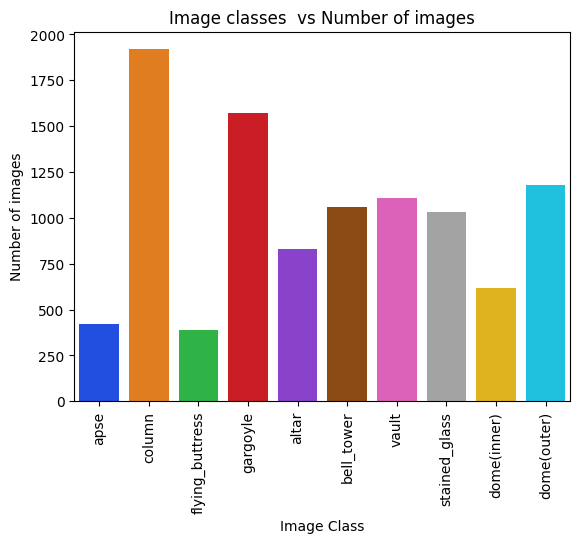

apse  column  flying_buttress  gargoyle  altar  bell_tower  vault  \
0   423    1919              387      1571    829        1059   1110   

   stained_glass  dome(inner)  dome(outer)  
0           1033          616         1177

In [47]:
import os
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt
import pathlib


def get_subdirectories(directory):
    with os.scandir(directory) as entries:
        return [entry.name for entry in entries if entry.is_dir()]
sub_dirs = get_subdirectories(pathlib.Path(train_data_path))
images = {}

for d in sub_dirs:

    images[d] = [len(os.listdir(train_data_path+'/'+d))]

df = pd.DataFrame(images)
sns.barplot(data = df ,palette= sns.color_palette("bright"))
plt.xlabel('Image Class')
plt.ylabel('Number of images')
plt.title(f'Image classes  vs Number of images' )
plt.xticks(rotation = 90)
plt.show()
df

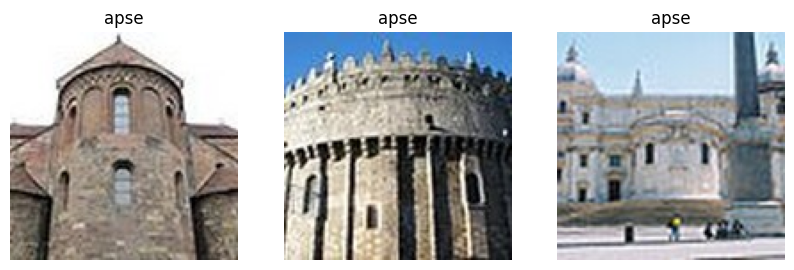

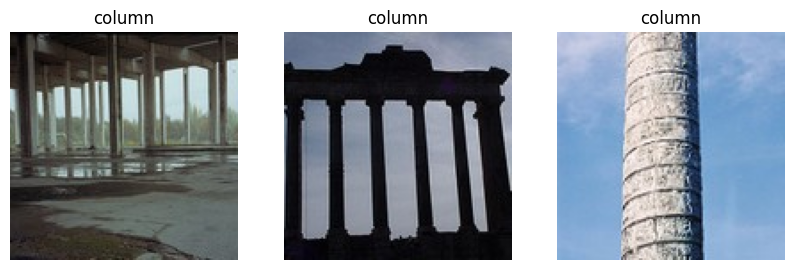

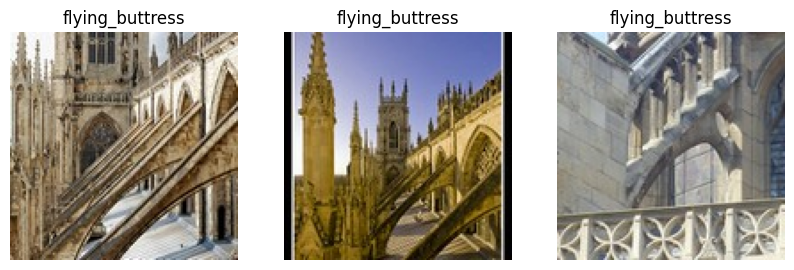

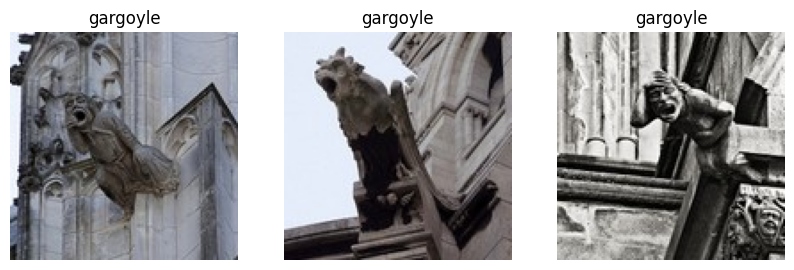

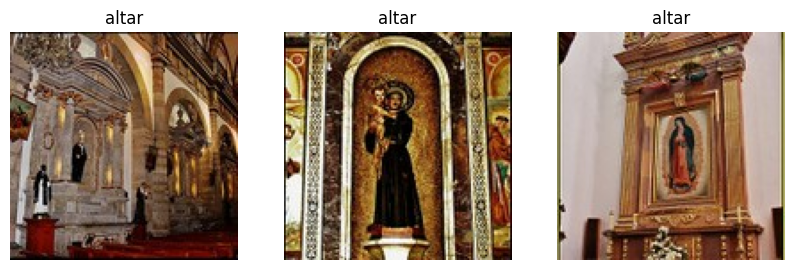

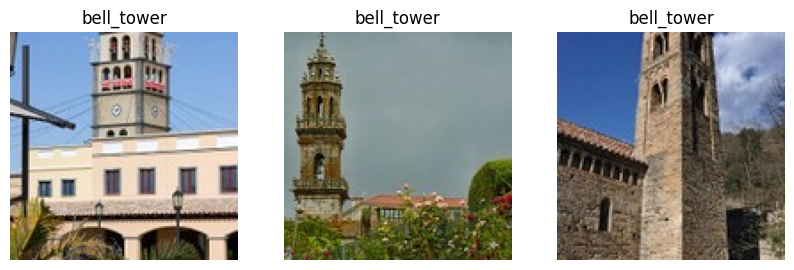

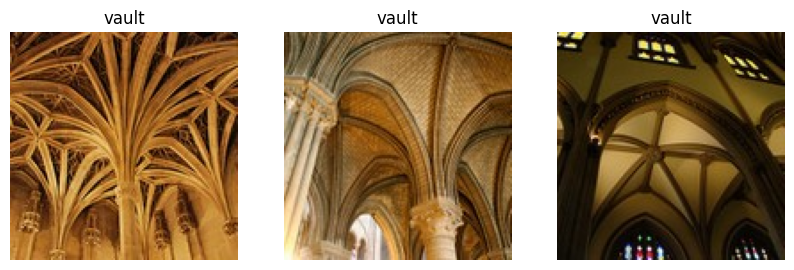

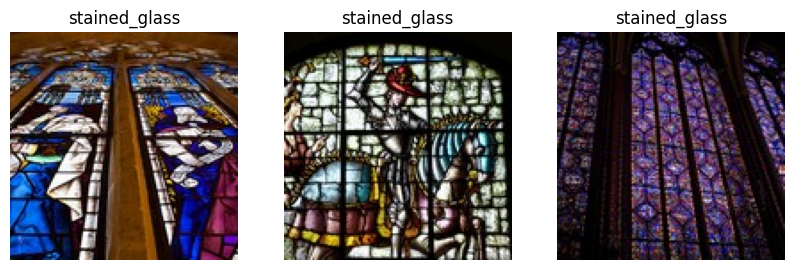

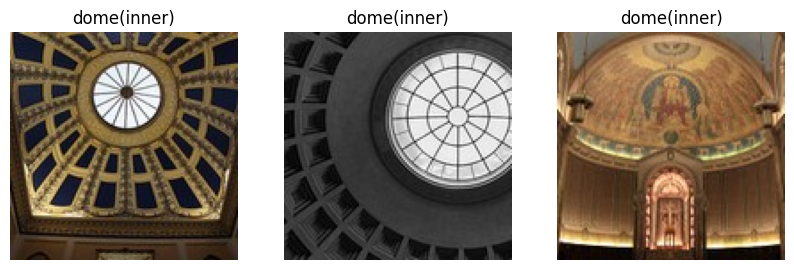

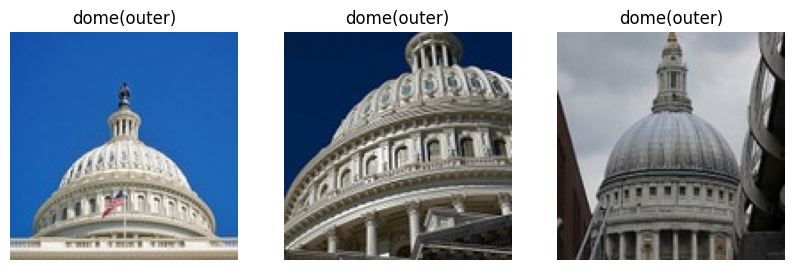

In [48]:
import matplotlib.pyplot as plt
import cv2
import os

for sub_dir in os.listdir(train_data_path):
    dir_path = os.path.join(train_data_path, sub_dir)
    is_dir = os.path.isdir(dir_path)
    if is_dir:
      plt.figure(figsize=(10,5))
      for i in range(3):
        file = os.listdir(dir_path)[i]
        file_path = os.path.join(dir_path, file)
        img = cv2.imread(file_path)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        plt.subplot(1,3,i+1)
        plt.title(sub_dir)
        plt.axis('off')
        plt.imshow(img)
      plt.show()

In [49]:
# create data sets
# using the latest tf.data for efficient input pipelines.
# https://www.tensorflow.org/guide/data

import tensorflow as tf
def get_ds(data_dir,seed = 43,subset='training',validation_split=0.2,image_size=(255,255),batch_size=32):
    train_ds = tf.keras.utils.image_dataset_from_directory(
    data_dir,
    seed=seed,
    validation_split = validation_split,
    subset=subset,
    image_size=image_size,
    batch_size=batch_size)
    train_ds.class_names
    return train_ds

data_dir = pathlib.Path(train_data_path)
train_ds = get_ds(data_dir,image_size=(height,width),batch_size=batch_size)
class_names = train_ds.class_names
print(class_names)
type(train_ds)

Found 10124 files belonging to 10 classes.
Using 8100 files for training.
['altar', 'apse', 'bell_tower', 'column', 'dome(inner)', 'dome(outer)', 'flying_buttress', 'gargoyle', 'stained_glass', 'vault']


tensorflow.python.data.ops.prefetch_op._PrefetchDataset

In [50]:
val_ds = get_ds(data_dir,subset='validation',image_size=(height,width),batch_size=batch_size)

Found 10124 files belonging to 10 classes.
Using 2024 files for validation.


In [51]:
AUTOTUNE = tf.data.AUTOTUNE
# caching data in a file system as caching all training data in memory can crash the runtime
# cache_file_train = '/data/cache.ttaining'
# cache_file_val = '/data/cache.val'
# train_ds = train_ds.cache(cache_file_train).shuffle(1000).prefetch(buffer_size=AUTOTUNE)
# val_ds = val_ds.cache(cache_file_val).shuffle(100).prefetch(buffer_size=AUTOTUNE)

train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)

In [52]:
# import library
from tensorflow.keras.models import Sequential
from tensorflow.keras import layers
from tensorflow import keras
import warnings
warnings.filterwarnings('ignore')

model = Sequential([
  ##--- starting data augmentation
  layers.RandomFlip("horizontal",input_shape=(height,width,3)),
  layers.RandomRotation(0.1),
  layers.RandomZoom(0.1),
  # layers.RandomShear(x_factor=0.1, y_factor=0.1),

  ##---- Data Augmentation ends

  # Image Scaling layer
  layers.Rescaling(1./255, input_shape=(height, width, 3)),

  # First convolution layer.convolution with 32 filters with a 3x3 kernel matrix
  layers.Conv2D(32, (3,3), padding='same', activation='relu'),
  layers.MaxPooling2D(), # Use max pooling

  # Second Convolution layer
  layers.Conv2D(32, (3,3), padding='same', activation='relu'),
  layers.MaxPooling2D(),

  # #Global Average Pooling layer. This does not work as GlobalAveragePooling makes
  # input dimension to the next layer incompatible(Maybe additional transformations are needed?)
  # layers.GlobalAveragePooling2D(),

  # 3rd Convolution layer
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),

  # 4th Convolution layer
  layers.Conv2D(128, 3, padding='same', activation='relu'),
  layers.GlobalMaxPooling2D(),


  layers.Flatten(),
  layers.Dense(128, activation='relu'),
  layers.Dense(128, activation='relu'),
  layers.Dropout(0.2),
  layers.Dense(len(class_names))

])

model.compile(optimizer='adam',
              # Recommended for sparse matrix data ( which images are)
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              #These do not work
              # metrics=[keras.metrics.Accuracy(),keras.metrics.Precision(),keras.metrics.Recall()]
              # metrics=['accuracy','precision','recall']
              metrics=['accuracy']
             )
model.summary()

Model: "sequential_9"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ random_flip_3 (RandomFlip)           │ (None, 224, 224, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ random_rotation_3 (RandomRotation)   │ (None, 224, 224, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ random_zoom_3 (RandomZoom)           │ (None, 224, 224, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ rescaling (Rescaling)                │ (None, 224, 224, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d (Conv2D)                      │ (None, 224, 224, 32)        │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 112, 112, 32)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 112, 112, 32)        │           9,248 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 56, 56, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 56, 56, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ (None, 28, 28, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_3 (Conv2D)                    │ (None, 28, 28, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_max_pooling2d                 │ (None, 128)                 │               0 │
│ (GlobalMaxPooling2D)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_17 (Dense)                     │ (None, 128)                 │          16,512 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_18 (Dense)                     │ (None, 128)                 │          16,512 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_12 (Dropout)                 │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_19 (Dense)                     │ (None, 10)                  │           1,290 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 136,810 (534.41 KB)

 Trainable params: 136,810 (534.41 KB)

 Non-trainable params: 0 (0.00 B)

In [53]:
from tensorflow.keras.callbacks import ModelCheckpoint

# Extending the ModelCheckPoint class
class MyCheckpoint(ModelCheckpoint):

    def __init__(self,
                 filepath,
                 monitor="val_loss",
                 verbose=0,
                 save_best_only=False,
                 save_weights_only=False,
                 mode="auto",
                 save_freq="epoch",
                 initial_value_threshold=None,
                 ):
        """
        :param filepath: where to save the model
        :param monitor: what to monitor
        :param verbose: 0 = silent, 1 = verbose
        :param save_best_only:
        :param save_weights_only:
        :param mode:
        :param save_freq:
        :param initial_value_threshold:
        """
        super().__init__(filepath,
                         monitor,
                         verbose,
                         save_best_only,
                         save_weights_only,
                         mode,
                         save_freq,
                         initial_value_threshold)

        self.last_epoch_number = 0
    # This function is called at the end of each epoch. I am overriding this method
    def on_epoch_end(self,epoch,logs=None):
        super().on_epoch_end(epoch,logs)
        self.last_epoch_number =  epoch+1
        print(f'epoch {self.last_epoch_number} completed')


In [54]:
from tensorflow.keras.callbacks import EarlyStopping


early_stop=EarlyStopping(monitor='val_loss',mode='min',verbose=1,patience=10,min_delta=0.01)
checkpoint=MyCheckpoint('best_model.keras',monitor='val_loss',mode='min',verbose=1,save_best_only=True)

epochs=100
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs,
  batch_size = batch_size,
  callbacks = [early_stop,checkpoint]
)

Epoch 1/100
127/127 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step - accuracy: 0.1929 - loss: 2.1534
Epoch 1: val_loss improved from inf to 1.59520, saving model to best_model.keras
epoch 1 completed
127/127 ━━━━━━━━━━━━━━━━━━━━ 22s 101ms/step - accuracy: 0.1933 - loss: 2.1522 - val_accuracy: 0.4091 - val_loss: 1.5952
Epoch 2/100
127/127 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step - accuracy: 0.3879 - loss: 1.6179
Epoch 2: val_loss improved from 1.59520 to 1.48090, saving model to best_model.keras
epoch 2 completed
127/127 ━━━━━━━━━━━━━━━━━━━━ 11s 83ms/step - accuracy: 0.3881 - loss: 1.6174 - val_accuracy: 0.4541 - val_loss: 1.4809
Epoch 3/100
127/127 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step - accuracy: 0.4925 - loss: 1.3981
Epoch 3: val_loss did not improve from 1.48090
epoch 3 completed
127/127 ━━━━━━━━━━━━━━━━━━━━ 11s 84ms/step - accuracy: 0.4926 - loss: 1.3978 - val_accuracy: 0.4333 - val_loss: 1.4906
Epoch 4/100
127/127 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step - accuracy: 0.5341 - loss: 1.2768
Epoch 4: val_loss impro

In [55]:
# print training accuracy
def print_scores(model,val_ds,train_ds,headline = None):
  print(headline)
  score_test = model.evaluate(val_ds, verbose=0)
  print('Test loss:%.4f' % score_test[0])
  print('Test accuracy:%.4f'% score_test[1])
  score_train= model.evaluate(train_ds, verbose=0)
  print('Train loss:%.4f'% score_train[0])
  print('train accuracy:%.4f'% score_train[1])


In [56]:
print_scores(model,val_ds,train_ds,'Only CNN Model')

Only CNN Model
Test loss:0.5600
Test accuracy:0.8118
Train loss:0.3709
train accuracy:0.8680


In [57]:
import matplotlib.pyplot as plt
def plot_accuracy_loss_graphs(history,title=None):
  acc = history.history['accuracy']
  val_acc = history.history['val_accuracy']

  loss = history.history['loss']
  val_loss = history.history['val_loss']
  epochs_range = range(checkpoint.last_epoch_number)

  plt.figure(figsize=(8, 8))
  plt.subplot(1, 2, 1)
  plt.plot(epochs_range, acc, label='Training Accuracy')
  plt.plot(epochs_range, val_acc, label='Validation Accuracy')
  plt.legend(loc='lower right')
  plt.title('Training and Validation Accuracy')

  plt.subplot(1, 2, 2)
  plt.plot(epochs_range, loss, label='Training Loss')
  plt.plot(epochs_range, val_loss, label='Validation Loss')
  plt.legend(loc='upper right')
  plt.title('Training and Validation Loss')

  plt.suptitle(f'Graphs for {title}')
  plt.show()


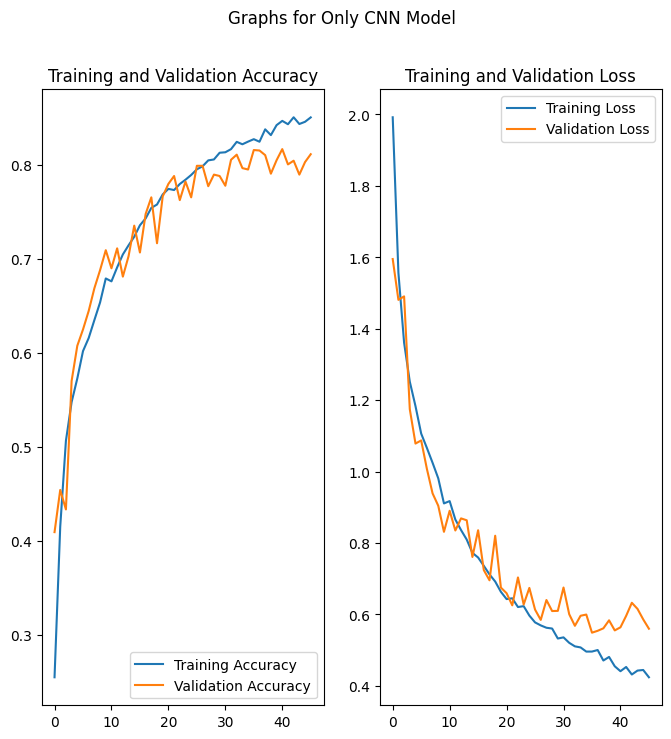

In [58]:
plot_accuracy_loss_graphs(history,'Only CNN Model')

# Transfer Model #

In [59]:

def tranfer_model_metrics(model):
  score_test = model.evaluate(val_ds, verbose=0)
  print('Test loss:%.4f' % score_test[0])
  print('Test accuracy:%.4f'% score_test[1])

In [60]:
from tensorflow.keras.applications.mobilenet_v2 import MobileNetV2
from tensorflow.keras.applications.vgg16 import VGG16
from tensorflow.keras.applications.inception_v3 import InceptionV3
from tensorflow.keras.applications.resnet50 import ResNet50
from tensorflow.keras.applications.xception import Xception

def run_model(model):
  print(model.name)
  model.trainable = False
  model = tf.keras.Sequential([
  tf.keras.layers.GlobalAveragePooling2D(),
  tf.keras.layers.Dense(len(class_names), activation='softmax')

])
  model.compile(optimizer='adam', loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True), metrics=['accuracy'])
  tranfer_model_metrics(model) 


model_m = tf.keras.applications.MobileNet(
    input_shape=(height,width,3),
    include_top=False,
    weights="imagenet",
    input_tensor=None,
    pooling=None,
    classes=1000,
    classifier_activation="softmax",
    name='MobileNet',
)
run_model(model_m)

model_v = tf.keras.applications.VGG16(
    include_top=False,
    weights="imagenet",
    input_tensor=None,
    input_shape=None,
    pooling=None,
    classes=1000,
    classifier_activation="softmax",
    name="vgg16",
)
run_model(model_v)


MobileNet
Test loss:114.8705
Test accuracy:0.1235
vgg16
Test loss:88.9104
Test accuracy:0.0459


**Transfer Model without Augmentation**

In [61]:
from tensorflow.keras.models import Sequential
from tensorflow.keras import layers
from tensorflow import keras
model_t = Sequential()
model_t.add(model_m)

#------------------------ Augmentation-------------------------------

# model_t.add(layers.RandomFlip("horizontal",input_shape=(height,width,3)))
# model_t.add(layers.RandomRotation(0.1))
# model_t.add(layers.RandomZoom(0.1))

#--------------------- Augmentation ends -------------------------

model_t.add(layers.GlobalAveragePooling2D())

## Dropout at 0.5 produces much lesse overfitting.
## Any lesser value increases training accuracy substantially, but testing acuracy doesnt improve
## Using Dropout as 0.1 as specified in the problem statement gives a training accuracy of 1, but a tetsing accuracy of 65%
## and results in worse classification
dropout = 0.5
model_t.add(layers.Dropout(dropout)) #


model_t.add(layers.Dense(256, activation='relu'))
model_t.add(layers.BatchNormalization())
model_t.add(layers.Dropout(dropout))

model_t.add(layers.Dense(128, activation='relu'))
model_t.add(layers.BatchNormalization())
model_t.add(layers.Dropout(dropout))

model_t.add(layers.Dense(len(class_names),activation='softmax'))
model_t.compile(optimizer='adam',
              # Recommended for sparse matrix data ( which images are)
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              #These do not work
              # metrics=[keras.metrics.Accuracy(),keras.metrics.Precision(),keras.metrics.Recall()]
              # metrics=['accuracy','precision','recall']
              metrics=['accuracy']
)
model_t.summary()

Model: "sequential_12"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ MobileNet (Functional)               │ (None, 7, 7, 1024)          │       3,228,864 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling2d_11          │ (None, 1024)                │               0 │
│ (GlobalAveragePooling2D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_13 (Dropout)                 │ (None, 1024)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_22 (Dense)                     │ (None, 256)                 │         262,400 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_8                │ (None, 256)                 │           1,024 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_14 (Dropout)                 │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_23 (Dense)                     │ (None, 128)                 │          32,896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_9                │ (None, 128)                 │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_15 (Dropout)                 │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_24 (Dense)                     │ (None, 10)                  │           1,290 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 3,526,986 (13.45 MB)

 Trainable params: 297,354 (1.13 MB)

 Non-trainable params: 3,229,632 (12.32 MB)

In [62]:
from tensorflow.keras.callbacks import EarlyStopping


early_stop=EarlyStopping(monitor='val_loss',mode='min',verbose=1,patience=10,min_delta=0.01)
checkpoint=MyCheckpoint('best_model.keras',monitor='val_loss',mode='min',verbose=1,save_best_only=True)

epochs=100
history = model_t.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs,
  batch_size = batch_size,
  callbacks = [early_stop,checkpoint]
)

Epoch 1/100
127/127 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step - accuracy: 0.2673 - loss: 2.5847
Epoch 1: val_loss improved from inf to 0.87266, saving model to best_model.keras
epoch 1 completed
127/127 ━━━━━━━━━━━━━━━━━━━━ 19s 96ms/step - accuracy: 0.2681 - loss: 2.5809 - val_accuracy: 0.7144 - val_loss: 0.8727
Epoch 2/100
127/127 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step - accuracy: 0.5539 - loss: 1.3861
Epoch 2: val_loss improved from 0.87266 to 0.71968, saving model to best_model.keras
epoch 2 completed
127/127 ━━━━━━━━━━━━━━━━━━━━ 7s 57ms/step - accuracy: 0.5541 - loss: 1.3856 - val_accuracy: 0.7648 - val_loss: 0.7197
Epoch 3/100
127/127 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step - accuracy: 0.6149 - loss: 1.1600
Epoch 3: val_loss improved from 0.71968 to 0.67466, saving model to best_model.keras
epoch 3 completed
127/127 ━━━━━━━━━━━━━━━━━━━━ 7s 57ms/step - accuracy: 0.6149 - loss: 1.1599 - val_accuracy: 0.7757 - val_loss: 0.6747
Epoch 4/100
127/127 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step - accuracy: 0.6469 - l

In [63]:
print_scores(model_t,val_ds,train_ds,'Transfer Model with no Augmentation')

None
Test loss:0.5244
Test accuracy:0.8192
Train loss:0.4141
train accuracy:0.8601


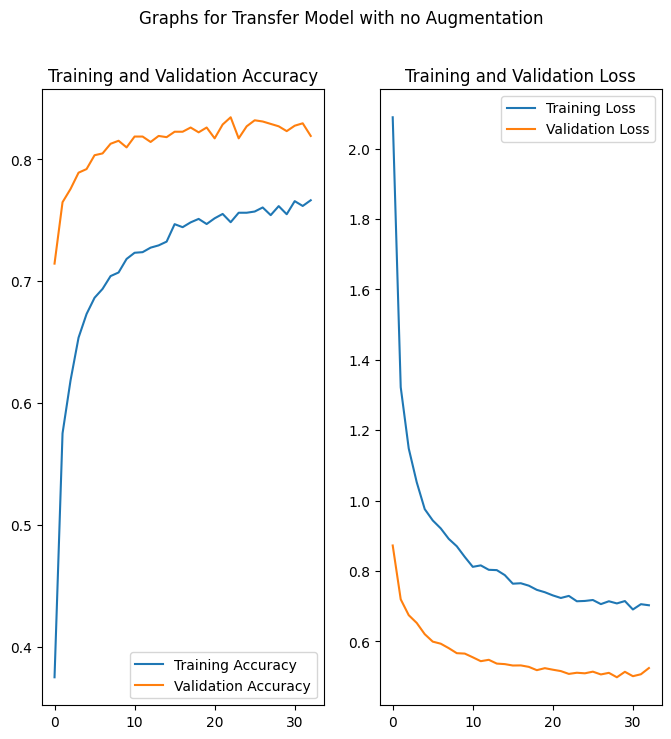

In [64]:
plot_accuracy_loss_graphs(history,'Transfer Model with no Augmentation')

In [65]:
from tensorflow.keras.models import Sequential
from tensorflow.keras import layers
from tensorflow import keras
model_t = Sequential()
model_t.add(model_m)

#------------------------ Augmentation-------------------------------

model_t.add(layers.RandomFlip("horizontal",input_shape=(height,width,3)))
model_t.add(layers.RandomRotation(0.1))
model_t.add(layers.RandomZoom(0.1))

#--------------------- Augmentation ends -------------------------
model_t.add(layers.GlobalAveragePooling2D())

## Dropout at 0.5 produces much lesse overfitting.
## Any lesser value increases training accuracy substantially, but testing acuracy doesnt improve
## Using Dropout as 0.1 as specified in the problem statement gives a training accuracy of 1, but a tetsing accuracy of 65%
## and results in worse classification
dropout = 0.5
model_t.add(layers.Dropout(dropout)) #


model_t.add(layers.Dense(256, activation='relu'))
model_t.add(layers.BatchNormalization())
model_t.add(layers.Dropout(dropout))

model_t.add(layers.Dense(128, activation='relu'))
model_t.add(layers.BatchNormalization())
model_t.add(layers.Dropout(dropout))

model_t.add(layers.Dense(len(class_names),activation='softmax'))
model_t.compile(optimizer='adam',
              # Recommended for sparse matrix data ( which images are)
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              #These do not work
              # metrics=[keras.metrics.Accuracy(),keras.metrics.Precision(),keras.metrics.Recall()]
              # metrics=['accuracy','precision','recall']
              metrics=['accuracy']
)
model_t.summary()

Model: "sequential_13"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ MobileNet (Functional)               │ (None, 7, 7, 1024)          │       3,228,864 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ random_flip_4 (RandomFlip)           │ (None, 7, 7, 1024)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ random_rotation_4 (RandomRotation)   │ (None, 7, 7, 1024)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ random_zoom_4 (RandomZoom)           │ (None, 7, 7, 1024)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling2d_12          │ (None, 1024)                │               0 │
│ (GlobalAveragePooling2D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_16 (Dropout)                 │ (None, 1024)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_25 (Dense)                     │ (None, 256)                 │         262,400 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_10               │ (None, 256)                 │           1,024 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_17 (Dropout)                 │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_26 (Dense)                     │ (None, 128)                 │          32,896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_11               │ (None, 128)                 │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_18 (Dropout)                 │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_27 (Dense)                     │ (None, 10)                  │           1,290 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 3,526,986 (13.45 MB)

 Trainable params: 297,354 (1.13 MB)

 Non-trainable params: 3,229,632 (12.32 MB)

In [66]:
early_stop=EarlyStopping(monitor='val_loss',mode='min',verbose=1,patience=10,min_delta=0.01)
checkpoint=MyCheckpoint('best_model.keras',monitor='val_loss',mode='min',verbose=1,save_best_only=True)

epochs=100
history = model_t.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs,
  batch_size = batch_size,
  callbacks = [early_stop,checkpoint]
)

Epoch 1/100
127/127 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step - accuracy: 0.2714 - loss: 2.5786
Epoch 1: val_loss improved from inf to 0.88524, saving model to best_model.keras
epoch 1 completed
127/127 ━━━━━━━━━━━━━━━━━━━━ 18s 109ms/step - accuracy: 0.2723 - loss: 2.5745 - val_accuracy: 0.7016 - val_loss: 0.8852
Epoch 2/100
127/127 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step - accuracy: 0.5655 - loss: 1.3729
Epoch 2: val_loss improved from 0.88524 to 0.73384, saving model to best_model.keras
epoch 2 completed
127/127 ━━━━━━━━━━━━━━━━━━━━ 13s 105ms/step - accuracy: 0.5656 - loss: 1.3726 - val_accuracy: 0.7446 - val_loss: 0.7338
Epoch 3/100
127/127 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step - accuracy: 0.6149 - loss: 1.1705
Epoch 3: val_loss improved from 0.73384 to 0.69737, saving model to best_model.keras
epoch 3 completed
127/127 ━━━━━━━━━━━━━━━━━━━━ 13s 104ms/step - accuracy: 0.6150 - loss: 1.1703 - val_accuracy: 0.7638 - val_loss: 0.6974
Epoch 4/100
127/127 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step - accuracy: 0.650

In [67]:
print_scores(model_t,val_ds,train_ds,'Transfer Model with Augmentation')

Transfer Model with Augmentation
Test loss:0.5119
Test accuracy:0.8286
Train loss:0.4043
train accuracy:0.8640


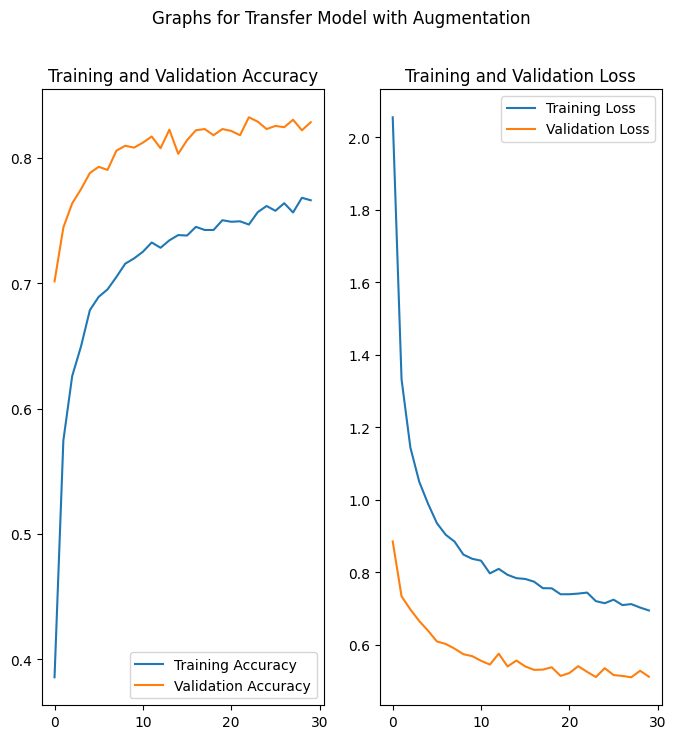

In [68]:
plot_accuracy_loss_graphs(history,'Transfer Model with Augmentation')

In [78]:
import numpy as np
import os



def get_predicted_labels(model,images):
    """
    :param model: the model to use for predictions
    :return: a dictionary of image path and image label derived from predictions
    """

    image_label_map = {}

    for i, path in enumerate(images):
        # path = test_dir+'/'+image
        img = tf.keras.utils.load_img(path, target_size=(height, width))
        img_array = tf.keras.utils.img_to_array(img)
        img_array = tf.expand_dims(img_array, 0) # Create a batch
        predictions = model.predict(img_array,verbose=False)
        score = tf.nn.softmax(predictions[0])
        max_score = np.max(score)
        image_label_map[path] = class_names[np.argmax(score)]
    return image_label_map


In [93]:
import matplotlib.image as mpimg

def display_test_images(image_map,model_name):
    print(f'Predictions for {model_name}\n')
    plt.figure(figsize=(15,15))
    for  i, image_path in enumerate(image_map.keys()):
        ax = plt.subplot(10,10,i+1)
        img = mpimg.imread(image_path)
        ax.imshow(img)
        ax.axis('off')
        label = image_map.get(image_path)
        plt.title(label)
        #ax.text(0.5, .8, label, fontsize=10,  color='cyan', ha='center', va='center',transform=ax.transAxes)
    plt.tight_layout()
    plt.show()

In [81]:
import os

def get_images(path):
    images = []
    for sub_dir in os.listdir(path):
        dir_path = os.path.join(path, sub_dir)
        is_dir = os.path.isdir(dir_path)
        if is_dir:
          for i in range(9):
            image = os.listdir(dir_path)[i]
            image_path = os.path.join(dir_path, image)
            images.append(image_path)
    return images

Predictions for Transfer model with Augmentation



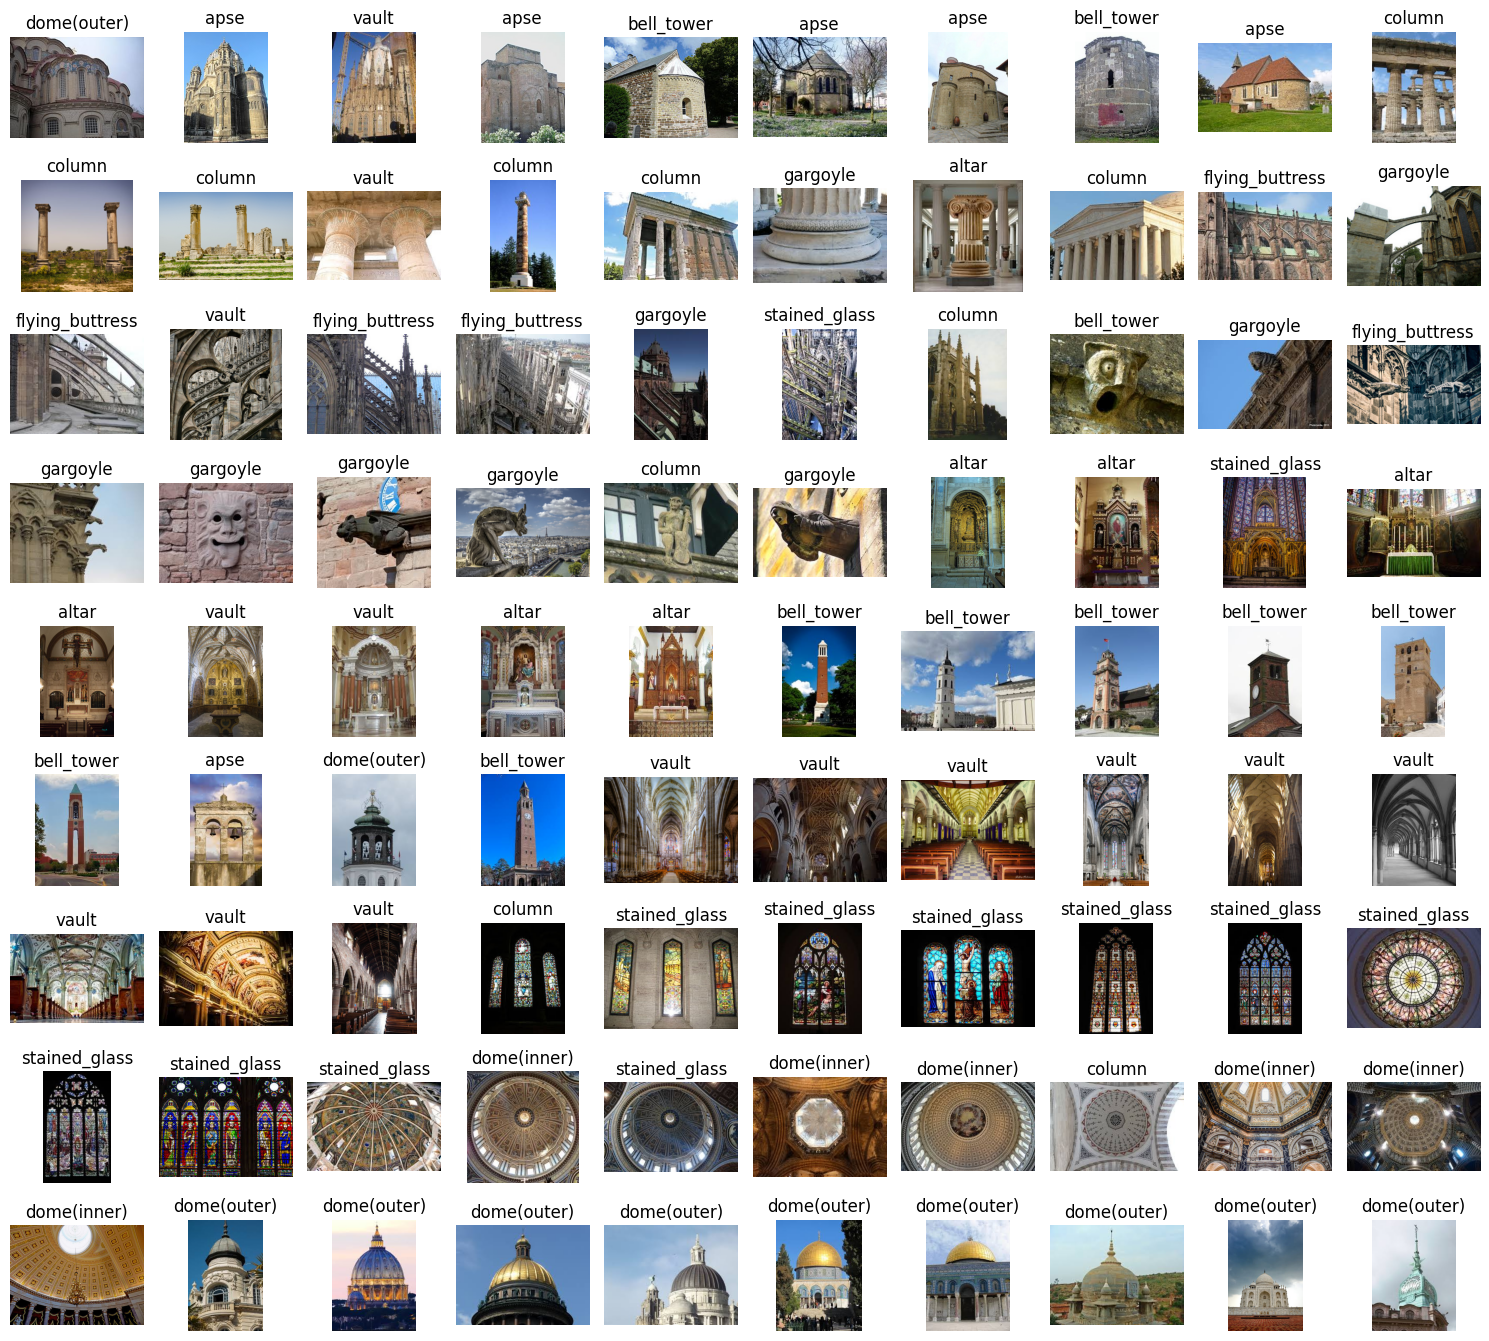

In [94]:
images = get_images(test_data_path)
image_label_map = get_predicted_labels(model_t,images)
display_test_images(image_label_map,'Transfer model with Augmentation')